# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
# %pip install tqdm pandas soundfile matplotlib

In [2]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/danya/develop/ITMO_ASR_labs_2025/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/danya/develop/ITMO_ASR_labs_2025/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/danya/develop/ITMO_ASR_labs_2025/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py

# Загрузка датасета TIMIT

Официальная страница датасета TIMIT 

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle 

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [3]:
# !pip install kaggle

In [4]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle 
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

# !kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

In [5]:
# !unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [6]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")
        
        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ", 
              f"{len(self.uri2wav)} wavs, ", 
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")
    
    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri
    
    
    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr 
        
    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text
    
    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words
    
    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes
    
    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}       

    def __len__(self):
        # TODO
        # верните количество элементов в выборке 
        return len(self.uris)

    def total_audio_samples(self) -> int:
        #TODO
        # верните суммарное количество отсчетов во всем аудио
        total_samples = 0
        for uri in self.uris:
            wav, sr = self.get_audio(uri)
            total_samples += len(wav)
        return total_samples

    def total_num_words(self) -> int:
        #TODO
        # верните суммарное количество слов в словном выравнивании
        total_words = 0
        for uri in self.uris:
            words = self.get_word_ali(uri)
            total_words += len(words)
        return total_words
    
    def total_num_phones(self) -> int:
        #TODO
        # верните суммарное количество фонем в фонемном выравнивании
        total_phones = 0
        for uri in self.uris:
            phones = self.get_phone_ali(uri)
            total_phones += len(phones)
        return total_phones
    
    def get_vocab(self) -> Set[str]:
        #TODO
        # верните словарь, состоящий из уникальных слов из выборки 
        vocab = set()
        for uri in self.uris:
            words = self.get_word_ali(uri)
            for _, _, word in words:
                vocab.add(word)
        return vocab

    def get_phones(self) -> Set[str]:
        #TODO
        # верните уникальный набор фонем, которые используются в выравнивании
        phones = set()
        for uri in self.uris:
            phone_ali = self.get_phone_ali(uri)
            for _, _, phone in phone_ali:
                phones.add(phone)
        return phones

    def phones_prior(self) -> Dict[str, float]:
        #TODO
        # верните мапинг фонемы в их априорные вероятности. 
        phone_counts = Counter()
        total_phones = 0
        
        for uri in self.uris:
            phone_ali = self.get_phone_ali(uri)
            for _, _, phone in phone_ali:
                phone_counts[phone] += 1
                total_phones += 1
        
        priors = {phone: count / total_phones for phone, count in phone_counts.items()}
        return priors
        

In [7]:

def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"
    
    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [8]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]

print("Audio data type:", type(item['audio'][0]))
print("Audio data attributes:", dir(item['audio'][0])[:10])  # First 10 attributes

# Check if it's a tensor from a specific library
if hasattr(item['audio'][0], 'numpy'):
    print("Has .numpy() method")
else:
    print("No .numpy() method available")

# Try to access the data directly
audio_data = item['audio'][0]
print("Shape/length:", len(audio_data) if hasattr(audio_data, '__len__') else "No length")

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Audio data type: <class 'torch.Tensor'>
Audio data attributes: ['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__']
Has .numpy() method
Shape/length: 53044


In [9]:
# test_ds = TimitDataset('timit/data/TEST/')
# item = test_ds[5]
# print(item['uri'])
# print(item['text'][2])
# display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
# print('---words---')
# for start, stop, word in item['word_ali']:
#     print(word)
#     display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
#     break

## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio. 

In [10]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_max=f_max
        )
        
        
    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        if num_samples < self.hop_length:
            return 1
        else:
            return 1 + num_samples // self.hop_length
    
    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.mel_spec.n_mels 
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        mel = self.mel_spec(waveform)
        mel = mel.squeeze(0)
        return mel

In [11]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"
        
    print('Test 1.b passed')
test_samples2frames()

100%|██████████| 25000/25000 [00:05<00:00, 4734.94it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи 

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание. 

In [12]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id 
phones = train_ds.get_phones() 
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1/FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (225

In [13]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id
    
    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание 
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # TODO 
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali 
        phone_ali = orig_item['phone_ali']
        fe = self.feature_extractor
        
        for start_sample, stop_sample, phone in phone_ali:
            phone_id = self.phone2id[phone]
            start_frame = fe.samples2frames(start_sample)
            stop_frame = fe.samples2frames(stop_sample)
            targets[start_frame:stop_frame] = phone_id 
        
        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets, 
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}
    
    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO 
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        max_len = max(item['feats'].shape[0] for item in batch)
        feat_dim = batch[0]['feats'].shape[1]
        batch_size = len(batch)
        
        feats = torch.zeros(max_len, batch_size, feat_dim)
        src_key_padding_mask = torch.ones(batch_size, max_len, dtype=torch.bool)
        targets_list = []
        
        for i, item in enumerate(batch):
            seq_len = item['feats'].shape[0]
            feats[:seq_len, i, :] = item['feats']
            src_key_padding_mask[i, :seq_len] = False
            targets_list.append(item['targets'])
        
        targets = torch.cat(targets_list)
        
        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }
        

In [14]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape
    
    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"
    
    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")
    
test_collate_pad()


Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации. 

In [15]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                 nhead=nhead, 
                                                 dim_feedforward=ff_dim, 
                                                 dropout=dropout, 
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)
        
        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO 
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой, 
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером 
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        positions = torch.arange(x.size(0), device=x.device).unsqueeze(1)
        pos_enc = self.positional_encoding(positions)
        x = x + pos_enc
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(x)
        
        return logits # (Time, Batch, Phones)

## 3. Обучение модели 

In [18]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()
        
    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции  
        src_key_padding_mask = batch['src_key_padding_mask']
        Time, Batch, num_phones = logits.shape
        
        logits_flat = []
        for b in range(Batch):
            valid_mask = ~src_key_padding_mask[b]
            logits_flat.append(logits[:, b, :][valid_mask])
        
        logits_flat = torch.cat(logits_flat, dim=0) 
        loss = self.criterion(logits_flat, batch['targets']) 
        
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}
        
    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO 
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке 
        # losses должен хранить значение ошибки на каждом батче 
        self.model.eval()
        with torch.no_grad():
            for batch in pbar:
                loss = self.forward(batch)
                losses.append(loss.item())
                pbar.set_description(f"validation loss {losses[-1]:.5f}") 
        
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()
                 
            
                

/home/danya/develop/ITMO_ASR_labs_2025/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

  1%|          | 1/160 [00:00<01:26,  1.84it/s]

train: 4.22573 | val: 3.95104


  1%|▏         | 2/160 [00:01<01:18,  2.00it/s]

train: 3.94561 | val: 3.77690


  2%|▏         | 3/160 [00:01<01:14,  2.10it/s]

train: 3.76870 | val: 3.68682


  2%|▎         | 4/160 [00:01<01:13,  2.13it/s]

train: 3.67816 | val: 3.62547


  3%|▎         | 5/160 [00:02<01:12,  2.15it/s]

train: 3.61711 | val: 3.56284


  4%|▍         | 6/160 [00:02<01:11,  2.15it/s]

train: 3.55488 | val: 3.50255


  4%|▍         | 7/160 [00:03<01:10,  2.16it/s]

train: 3.49513 | val: 3.45514


  5%|▌         | 8/160 [00:03<01:09,  2.18it/s]

train: 3.44836 | val: 3.42315


  6%|▌         | 9/160 [00:04<01:09,  2.18it/s]

train: 3.41701 | val: 3.40025


  6%|▋         | 10/160 [00:04<01:08,  2.19it/s]

train: 3.39457 | val: 3.37847


  7%|▋         | 11/160 [00:05<01:08,  2.18it/s]

train: 3.37305 | val: 3.35391


  8%|▊         | 12/160 [00:05<01:07,  2.18it/s]

train: 3.34858 | val: 3.32723


  8%|▊         | 13/160 [00:06<01:07,  2.18it/s]

train: 3.32184 | val: 3.30112


  9%|▉         | 14/160 [00:06<01:07,  2.18it/s]

train: 3.29557 | val: 3.27811


  9%|▉         | 15/160 [00:06<01:06,  2.17it/s]

train: 3.27239 | val: 3.25859


 10%|█         | 16/160 [00:07<01:06,  2.18it/s]

train: 3.25278 | val: 3.24041


 11%|█         | 17/160 [00:07<01:05,  2.18it/s]

train: 3.23463 | val: 3.22078


 11%|█▏        | 18/160 [00:08<01:05,  2.17it/s]

train: 3.21525 | val: 3.19856


 12%|█▏        | 19/160 [00:08<01:04,  2.18it/s]

train: 3.19349 | val: 3.17506


 12%|█▎        | 20/160 [00:09<01:03,  2.20it/s]

train: 3.17060 | val: 3.15220


 13%|█▎        | 21/160 [00:09<01:03,  2.20it/s]

train: 3.14839 | val: 3.13016


 14%|█▍        | 22/160 [00:10<01:02,  2.20it/s]

train: 3.12688 | val: 3.10717


 14%|█▍        | 23/160 [00:10<01:02,  2.20it/s]

train: 3.10424 | val: 3.08170


 15%|█▌        | 24/160 [00:11<01:01,  2.20it/s]

train: 3.07892 | val: 3.05395


 16%|█▌        | 25/160 [00:11<01:01,  2.21it/s]

train: 3.05117 | val: 3.02531


 16%|█▋        | 26/160 [00:11<01:00,  2.21it/s]

train: 3.02248 | val: 2.99669


 17%|█▋        | 27/160 [00:12<01:00,  2.21it/s]

train: 2.99384 | val: 2.96777


 18%|█▊        | 28/160 [00:12<00:59,  2.21it/s]

train: 2.96496 | val: 2.93795


 18%|█▊        | 29/160 [00:13<00:59,  2.19it/s]

train: 2.93526 | val: 2.90750


 19%|█▉        | 30/160 [00:13<00:59,  2.18it/s]

train: 2.90494 | val: 2.87733


 19%|█▉        | 31/160 [00:14<00:58,  2.20it/s]

train: 2.87483 | val: 2.84761


 20%|██        | 32/160 [00:14<00:57,  2.21it/s]

train: 2.84507 | val: 2.81774


 21%|██        | 33/160 [00:15<00:57,  2.21it/s]

train: 2.81500 | val: 2.78781


 21%|██▏       | 34/160 [00:15<00:56,  2.22it/s]

train: 2.78481 | val: 2.75831


 22%|██▏       | 35/160 [00:16<00:56,  2.21it/s]

train: 2.75511 | val: 2.72891


 22%|██▎       | 36/160 [00:16<00:56,  2.21it/s]

train: 2.72568 | val: 2.69910


 23%|██▎       | 37/160 [00:16<00:55,  2.21it/s]

train: 2.69602 | val: 2.66922


 24%|██▍       | 38/160 [00:17<00:55,  2.21it/s]

train: 2.66638 | val: 2.63978


 24%|██▍       | 39/160 [00:17<00:54,  2.20it/s]

train: 2.63716 | val: 2.61051


 25%|██▌       | 40/160 [00:18<00:54,  2.21it/s]

train: 2.60804 | val: 2.58109


 26%|██▌       | 41/160 [00:18<00:54,  2.20it/s]

train: 2.57876 | val: 2.55186


 26%|██▋       | 42/160 [00:19<00:53,  2.19it/s]

train: 2.54973 | val: 2.52266


 27%|██▋       | 43/160 [00:19<00:53,  2.19it/s]

train: 2.52081 | val: 2.49342


 28%|██▊       | 44/160 [00:20<00:53,  2.19it/s]

train: 2.49190 | val: 2.46449


 28%|██▊       | 45/160 [00:20<00:52,  2.18it/s]

train: 2.46325 | val: 2.43564


 29%|██▉       | 46/160 [00:21<00:52,  2.18it/s]

train: 2.43463 | val: 2.40678


 29%|██▉       | 47/160 [00:21<00:51,  2.19it/s]

train: 2.40595 | val: 2.37831


 30%|███       | 48/160 [00:21<00:51,  2.19it/s]

train: 2.37763 | val: 2.34981


 31%|███       | 49/160 [00:22<00:50,  2.19it/s]

train: 2.34931 | val: 2.32130


 31%|███▏      | 50/160 [00:22<00:50,  2.18it/s]

train: 2.32103 | val: 2.29339


 32%|███▏      | 51/160 [00:23<00:49,  2.19it/s]

train: 2.29336 | val: 2.26564


 32%|███▎      | 52/160 [00:23<00:49,  2.17it/s]

train: 2.26579 | val: 2.23806


 33%|███▎      | 53/160 [00:24<00:48,  2.19it/s]

train: 2.23836 | val: 2.21095


 34%|███▍      | 54/160 [00:24<00:48,  2.18it/s]

train: 2.21143 | val: 2.18388


 34%|███▍      | 55/160 [00:25<00:48,  2.18it/s]

train: 2.18458 | val: 2.15717


 35%|███▌      | 56/160 [00:25<00:47,  2.17it/s]

train: 2.15812 | val: 2.13064


 36%|███▌      | 57/160 [00:26<00:47,  2.17it/s]

train: 2.13180 | val: 2.10428


 36%|███▋      | 58/160 [00:26<00:46,  2.18it/s]

train: 2.10563 | val: 2.07816


 37%|███▋      | 59/160 [00:27<00:46,  2.18it/s]

train: 2.07967 | val: 2.05218


 38%|███▊      | 60/160 [00:27<00:45,  2.18it/s]

train: 2.05380 | val: 2.02653


 38%|███▊      | 61/160 [00:27<00:45,  2.20it/s]

train: 2.02828 | val: 2.00098


 39%|███▉      | 62/160 [00:28<00:44,  2.21it/s]

train: 2.00285 | val: 1.97578


 39%|███▉      | 63/160 [00:28<00:44,  2.20it/s]

train: 1.97778 | val: 1.95075


 40%|████      | 64/160 [00:29<00:43,  2.18it/s]

train: 1.95288 | val: 1.92604


 41%|████      | 65/160 [00:29<00:43,  2.19it/s]

train: 1.92829 | val: 1.90149


 41%|████▏     | 66/160 [00:30<00:42,  2.20it/s]

train: 1.90387 | val: 1.87718


 42%|████▏     | 67/160 [00:30<00:42,  2.21it/s]

train: 1.87966 | val: 1.85310


 42%|████▎     | 68/160 [00:31<00:41,  2.21it/s]

train: 1.85568 | val: 1.82930


 43%|████▎     | 69/160 [00:31<00:41,  2.21it/s]

train: 1.83196 | val: 1.80561


 44%|████▍     | 70/160 [00:32<00:40,  2.21it/s]

train: 1.80834 | val: 1.78215


 44%|████▍     | 71/160 [00:32<00:40,  2.22it/s]

train: 1.78495 | val: 1.75884


 45%|████▌     | 72/160 [00:32<00:39,  2.20it/s]

train: 1.76169 | val: 1.73572


 46%|████▌     | 73/160 [00:33<00:39,  2.20it/s]

train: 1.73863 | val: 1.71274


 46%|████▋     | 74/160 [00:33<00:38,  2.21it/s]

train: 1.71570 | val: 1.68990


 47%|████▋     | 75/160 [00:34<00:38,  2.20it/s]

train: 1.69290 | val: 1.66733


 48%|████▊     | 76/160 [00:34<00:38,  2.20it/s]

train: 1.67039 | val: 1.64493


 48%|████▊     | 77/160 [00:35<00:37,  2.19it/s]

train: 1.64808 | val: 1.62273


 49%|████▉     | 78/160 [00:35<00:37,  2.20it/s]

train: 1.62598 | val: 1.60063


 49%|████▉     | 79/160 [00:36<00:36,  2.20it/s]

train: 1.60397 | val: 1.57863


 50%|█████     | 80/160 [00:36<00:36,  2.18it/s]

train: 1.58205 | val: 1.55672


 51%|█████     | 81/160 [00:37<00:36,  2.18it/s]

train: 1.56021 | val: 1.53489


 51%|█████▏    | 82/160 [00:37<00:35,  2.19it/s]

train: 1.53845 | val: 1.51314


 52%|█████▏    | 83/160 [00:37<00:35,  2.19it/s]

train: 1.51678 | val: 1.49146


 52%|█████▎    | 84/160 [00:38<00:34,  2.20it/s]

train: 1.49516 | val: 1.46976


 53%|█████▎    | 85/160 [00:38<00:34,  2.20it/s]

train: 1.47350 | val: 1.44810


 54%|█████▍    | 86/160 [00:39<00:33,  2.20it/s]

train: 1.45186 | val: 1.42656


 54%|█████▍    | 87/160 [00:39<00:33,  2.21it/s]

train: 1.43035 | val: 1.40526


 55%|█████▌    | 88/160 [00:40<00:32,  2.21it/s]

train: 1.40907 | val: 1.38415


 56%|█████▌    | 89/160 [00:40<00:32,  2.20it/s]

train: 1.38799 | val: 1.36321


 56%|█████▋    | 90/160 [00:41<00:31,  2.19it/s]

train: 1.36708 | val: 1.34240


 57%|█████▋    | 91/160 [00:41<00:31,  2.21it/s]

train: 1.34628 | val: 1.32170


 57%|█████▊    | 92/160 [00:42<00:30,  2.21it/s]

train: 1.32560 | val: 1.30111


 58%|█████▊    | 93/160 [00:42<00:30,  2.20it/s]

train: 1.30500 | val: 1.28062


 59%|█████▉    | 94/160 [00:42<00:30,  2.19it/s]

train: 1.28449 | val: 1.26027


 59%|█████▉    | 95/160 [00:43<00:29,  2.20it/s]

train: 1.26411 | val: 1.24006


 60%|██████    | 96/160 [00:43<00:29,  2.21it/s]

train: 1.24386 | val: 1.22000


 61%|██████    | 97/160 [00:44<00:28,  2.20it/s]

train: 1.22375 | val: 1.20006


 61%|██████▏   | 98/160 [00:44<00:28,  2.17it/s]

train: 1.20375 | val: 1.18023


 62%|██████▏   | 99/160 [00:45<00:27,  2.18it/s]

train: 1.18384 | val: 1.16046


 62%|██████▎   | 100/160 [00:45<00:27,  2.18it/s]

train: 1.16396 | val: 1.14077


 63%|██████▎   | 101/160 [00:46<00:27,  2.18it/s]

train: 1.14416 | val: 1.12123


 64%|██████▍   | 102/160 [00:46<00:26,  2.19it/s]

train: 1.12453 | val: 1.10182


 64%|██████▍   | 103/160 [00:47<00:25,  2.20it/s]

train: 1.10502 | val: 1.08249


 65%|██████▌   | 104/160 [00:47<00:25,  2.19it/s]

train: 1.08561 | val: 1.06327


 66%|██████▌   | 105/160 [00:47<00:25,  2.17it/s]

train: 1.06632 | val: 1.04420


 66%|██████▋   | 106/160 [00:48<00:24,  2.18it/s]

train: 1.04718 | val: 1.02526


 67%|██████▋   | 107/160 [00:48<00:24,  2.16it/s]

train: 1.02817 | val: 1.00648


 68%|██████▊   | 108/160 [00:49<00:24,  2.16it/s]

train: 1.00930 | val: 0.98782


 68%|██████▊   | 109/160 [00:49<00:23,  2.16it/s]

train: 0.99057 | val: 0.96932


 69%|██████▉   | 110/160 [00:50<00:23,  2.17it/s]

train: 0.97200 | val: 0.95103


 69%|██████▉   | 111/160 [00:50<00:22,  2.17it/s]

train: 0.95366 | val: 0.93308


 70%|███████   | 112/160 [00:51<00:22,  2.18it/s]

train: 0.93565 | val: 0.91577


 71%|███████   | 113/160 [00:51<00:21,  2.16it/s]

train: 0.91836 | val: 0.89951


 71%|███████▏  | 114/160 [00:52<00:21,  2.16it/s]

train: 0.90213 | val: 0.88328


 72%|███████▏  | 115/160 [00:52<00:20,  2.15it/s]

train: 0.88596 | val: 0.86465


 72%|███████▎  | 116/160 [00:53<00:20,  2.16it/s]

train: 0.86719 | val: 0.84625


 73%|███████▎  | 117/160 [00:53<00:19,  2.16it/s]

train: 0.84873 | val: 0.83238


 74%|███████▍  | 118/160 [00:53<00:19,  2.16it/s]

train: 0.83515 | val: 0.81795


 74%|███████▍  | 119/160 [00:54<00:19,  2.15it/s]

train: 0.82081 | val: 0.79898


 75%|███████▌  | 120/160 [00:54<00:18,  2.16it/s]

train: 0.80161 | val: 0.78200


 76%|███████▌  | 121/160 [00:55<00:18,  2.16it/s]

train: 0.78455 | val: 0.76644


 76%|███████▋  | 122/160 [00:55<00:17,  2.17it/s]

train: 0.76897 | val: 0.74988


 77%|███████▋  | 123/160 [00:56<00:17,  2.17it/s]

train: 0.75237 | val: 0.73628


 78%|███████▊  | 124/160 [00:56<00:16,  2.18it/s]

train: 0.73886 | val: 0.71966


 78%|███████▊  | 125/160 [00:57<00:16,  2.17it/s]

train: 0.72219 | val: 0.70323


 79%|███████▉  | 126/160 [00:57<00:15,  2.17it/s]

train: 0.70573 | val: 0.69038


 79%|███████▉  | 127/160 [00:58<00:15,  2.17it/s]

train: 0.69305 | val: 0.67477


 80%|████████  | 128/160 [00:58<00:14,  2.17it/s]

train: 0.67738 | val: 0.65993


 81%|████████  | 129/160 [00:59<00:14,  2.17it/s]

train: 0.66261 | val: 0.64561


 81%|████████▏ | 130/160 [00:59<00:13,  2.18it/s]

train: 0.64835 | val: 0.63067


 82%|████████▏ | 131/160 [00:59<00:13,  2.18it/s]

train: 0.63338 | val: 0.61746


 82%|████████▎ | 132/160 [01:00<00:12,  2.18it/s]

train: 0.62029 | val: 0.60331


 83%|████████▎ | 133/160 [01:00<00:12,  2.18it/s]

train: 0.60624 | val: 0.58918


 84%|████████▍ | 134/160 [01:01<00:11,  2.18it/s]

train: 0.59207 | val: 0.57553


 84%|████████▍ | 135/160 [01:01<00:11,  2.17it/s]

train: 0.57848 | val: 0.56165


 85%|████████▌ | 136/160 [01:02<00:10,  2.18it/s]

train: 0.56462 | val: 0.54889


 86%|████████▌ | 137/160 [01:02<00:10,  2.19it/s]

train: 0.55193 | val: 0.53580


 86%|████████▋ | 138/160 [01:03<00:10,  2.19it/s]

train: 0.53890 | val: 0.52349


 87%|████████▋ | 139/160 [01:03<00:09,  2.18it/s]

train: 0.52663 | val: 0.51199


 88%|████████▊ | 140/160 [01:04<00:09,  2.18it/s]

train: 0.51527 | val: 0.50027


 88%|████████▊ | 141/160 [01:04<00:08,  2.17it/s]

train: 0.50368 | val: 0.49139


 89%|████████▉ | 142/160 [01:05<00:08,  2.17it/s]

train: 0.49513 | val: 0.47623


 89%|████████▉ | 143/160 [01:05<00:07,  2.18it/s]

train: 0.47960 | val: 0.46279


 90%|█████████ | 144/160 [01:05<00:07,  2.18it/s]

train: 0.46603 | val: 0.45139


 91%|█████████ | 145/160 [01:06<00:06,  2.18it/s]

train: 0.45464 | val: 0.44125


 91%|█████████▏| 146/160 [01:06<00:06,  2.18it/s]

train: 0.44459 | val: 0.43177


 92%|█████████▏| 147/160 [01:07<00:05,  2.18it/s]

train: 0.43535 | val: 0.41979


 92%|█████████▎| 148/160 [01:07<00:05,  2.17it/s]

train: 0.42316 | val: 0.40781


 93%|█████████▎| 149/160 [01:08<00:05,  2.16it/s]

train: 0.41095 | val: 0.39712


 94%|█████████▍| 150/160 [01:08<00:04,  2.18it/s]

train: 0.40019 | val: 0.38798


 94%|█████████▍| 151/160 [01:09<00:04,  2.18it/s]

train: 0.39104 | val: 0.37914


 95%|█████████▌| 152/160 [01:09<00:03,  2.17it/s]

train: 0.38230 | val: 0.36799


 96%|█████████▌| 153/160 [01:10<00:03,  2.17it/s]

train: 0.37099 | val: 0.35751


 96%|█████████▋| 154/160 [01:10<00:02,  2.17it/s]

train: 0.36035 | val: 0.34839


 97%|█████████▋| 155/160 [01:10<00:02,  2.17it/s]

train: 0.35120 | val: 0.34007


 98%|█████████▊| 156/160 [01:11<00:01,  2.18it/s]

train: 0.34290 | val: 0.33173


 98%|█████████▊| 157/160 [01:11<00:01,  2.17it/s]

train: 0.33465 | val: 0.32212


 99%|█████████▉| 158/160 [01:12<00:00,  2.17it/s]

train: 0.32485 | val: 0.31301


 99%|█████████▉| 159/160 [01:12<00:00,  2.17it/s]

train: 0.31565 | val: 0.30448


100%|██████████| 160/160 [01:13<00:00,  2.18it/s]

train: 0.30704 | val: 0.29670


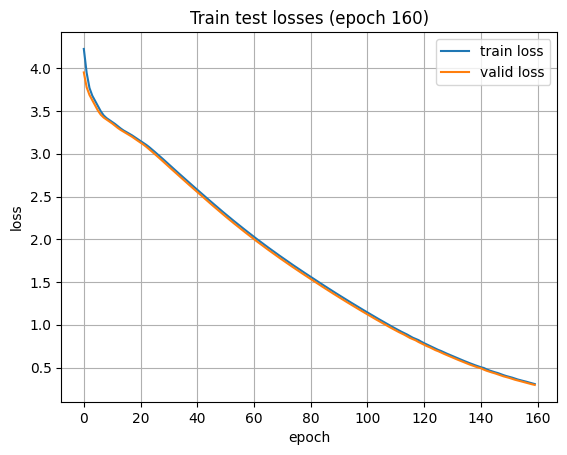

validation loss 0.31050: 100%|██████████| 10/10 [00:00<00:00, 88.80it/s]

Test 3.a passed


In [19]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit 
    # Для этого запускается обучение на одном батче данных. 
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть. 
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                   out_dim=max(PHONE2ID.values()) + 1,  
                                   dim=256, 
                                   num_layers=6, 
                                   ff_dim=512, 
                                   dropout=0.0, 
                                   nhead=8), 
                      fe=fe, 
                      phone2id=PHONE2ID, device='cuda')
   
    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))
    
    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well" 
    print(f"Test 3.a passed")
overfit_one_batch_check()

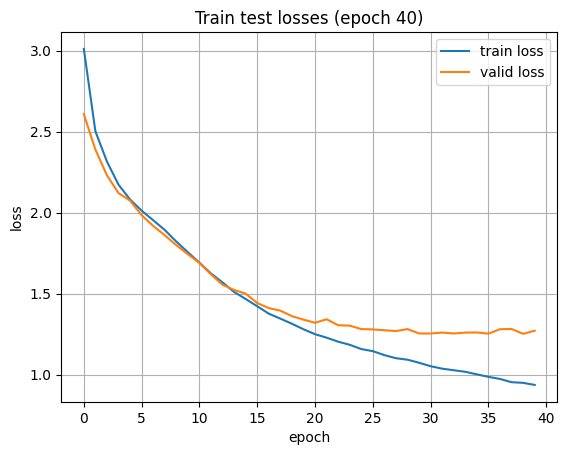

100%|██████████| 40/40 [1:18:16<00:00, 117.40s/it]


In [ ]:

def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=40, 
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                 out_dim=max(PHONE2ID.values())+1, 
                                 dim=192, 
                                 num_layers=4, 
                                 ff_dim=256, 
                                 dropout=0.1, 
                                 nhead=4),
                     fe=fe, 
                     opt_kwargs={'lr':0.001},
                     phone2id=PHONE2ID, device='cuda')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [24]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9 

**Дополнительное задание** (4 балла): Улучшите loss до 1.3 

In [25]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")
test_trained_model(results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


validation loss 1.61581: 100%|██████████| 1680/1680 [00:14<00:00, 112.28it/s]

Test loss is 1.271092196128198
Main task is done! (12 points)
Additional task is done! (+4 points)
